In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train_images/3412658650.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/3269782382.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/3017918878.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/641852090.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/1184927419.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/657823258.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/1002394761.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/1946708779.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/2885347871.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/1848213383.jpg
/kaggle/in

## Libraries
* Importing fasai.vision to work with 
* Importing seaborn and PIL for EDA and data visualisation

In [2]:
from fastai.vision.all import *

In [3]:
import seaborn as sns
from PIL import Image

In [4]:
# To make our result reproducible
set_seed(16)

## Loading given data

In [5]:
train = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
submission = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv')

In [6]:
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


* Every image has a label
* We have more than 2 labels present in our train.csv
* We are working with a multi-label classification problem here
* A few lines below we will find out out what theses labels mean

### Make a path and view all the files available to us

In [7]:
path = Path('/kaggle/input')
data_present = path/'cassava-leaf-disease-classification'
print('List of files present in cassava-leaf-disease-classification are')
data_present.ls()

List of files present in cassava-leaf-disease-classification are


(#7) [Path('/kaggle/input/cassava-leaf-disease-classification/train_images'),Path('/kaggle/input/cassava-leaf-disease-classification/test_images'),Path('/kaggle/input/cassava-leaf-disease-classification/test_tfrecords'),Path('/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/train.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('/kaggle/input/cassava-leaf-disease-classification/train_tfrecords')]

### Getting image files names from our train_images folder 

In [8]:
def get_x(r): return data_present/'train_images'/r['image_id']
img = get_x(train.iloc[0])

In [9]:
train['image_id'] = train['image_id'].apply(lambda x: f'train_images/{x}')
train.head()

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3


**Replacing the labels with provided names for the lables in the data/**

# EDA

### Lets replace the label names with what they mean to make it easier to read them

In [10]:
ind_tolbl = {0:"Cassava Bacterial Blight (CBB)",
             1:"Cassava Brown Streak Disease (CBSD)",
             2:"Cassava Green Mottle (CGM)",
             3:"Cassava Mosaic Disease (CMD)",
             4:"Healthy"}
train['label'].replace(ind_tolbl, inplace = True)

In [11]:
train.head(10)

,image_id,label
0,train_images/1000015157.jpg,Cassava Bacterial Blight (CBB)
1,train_images/1000201771.jpg,Cassava Mosaic Disease (CMD)
2,train_images/100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,train_images/1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,train_images/1000812911.jpg,Cassava Mosaic Disease (CMD)
5,train_images/1000837476.jpg,Cassava Mosaic Disease (CMD)
6,train_images/1000910826.jpg,Cassava Green Mottle (CGM)
7,train_images/1001320321.jpg,Cassava Bacterial Blight (CBB)
8,train_images/1001723730.jpg,Healthy
9,train_images/1001742395.jpg,Cassava Mosaic Disease (CMD)


The availability of each label present in our dataset


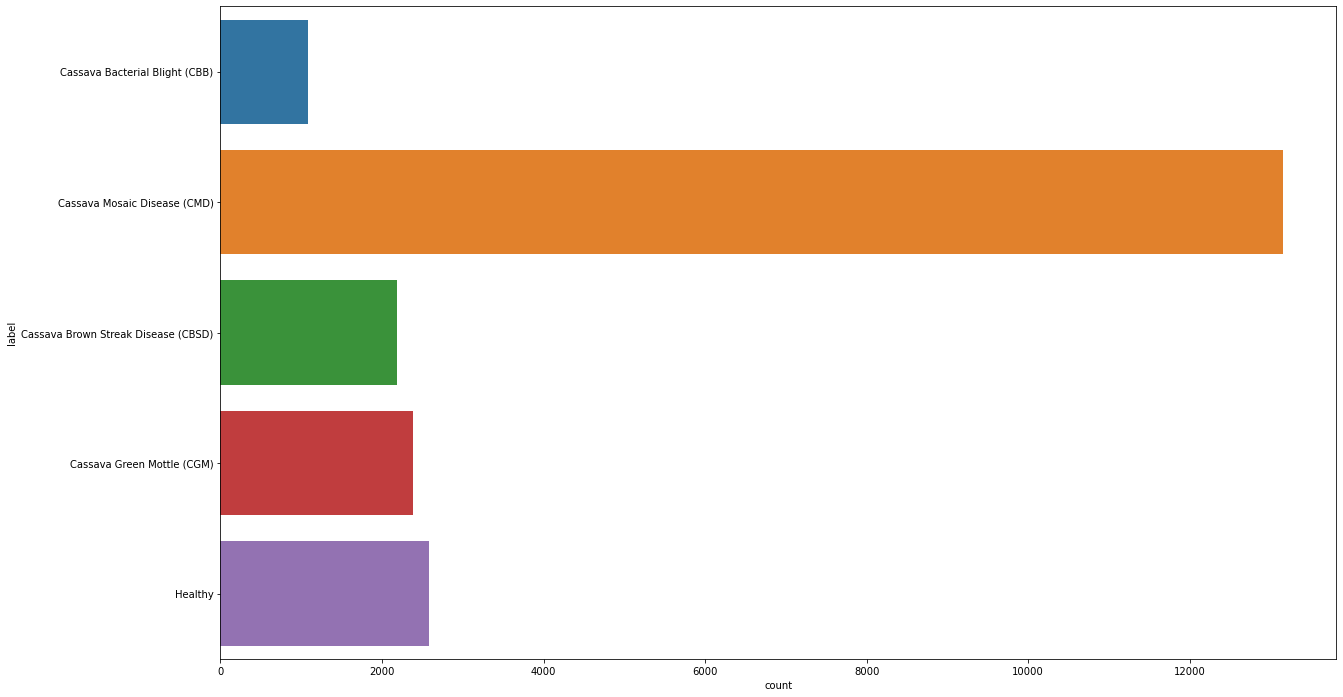

In [12]:
plt.figure(figsize = (20, 12))
sns.countplot(y = 'label',data = train)
print('The availability of each label present in our dataset')

* From the above plot we find the we have more tham 12000 images of CMD available
* Cassava Bacterial Blight (CBB) images are the least present in our dataset
* We have fair amount of healthy images of plants to train our dataset on

In [13]:
print(f"Cassava Bacterial Blight (CBB) present in training set: {len(train[train['label'] == 'Cassava Bacterial Blight (CBB)'])}")
print(f"Cassava Mosaic Disease (CMD) present in training set: {len(train[train['label'] == 'Cassava Mosaic Disease (CMD)'].values)}")
print(f"Cassava Green Mottle (CGM) present in training set: {len(train[train['label'] == 'Cassava Green Mottle (CGM)'].values)}")
print(f"Cassava Brown Streak Disease (CBSD) present in training set: {len(train[train['label'] == 'Cassava Brown Streak Disease (CBSD)'].values)}")
print(f"healthy plants present in training set: {len(train[train['label'] == 'Healthy'].values)}")

Cassava Bacterial Blight (CBB) present in training set: 1087
Cassava Mosaic Disease (CMD) present in training set: 13158
Cassava Green Mottle (CGM) present in training set: 2386
Cassava Brown Streak Disease (CBSD) present in training set: 2189
healthy plants present in training set: 2577


In [14]:
def get_x(r): return data_present/r['image_id']
def get_y(r): return r['label']

* The batch_tfms does a batch transformation of our images at GPU time to make it faster 
* Note: fastai default augmentation of our images is done but addtional parameters can be used
* Our data is normalized using Imagenet, since our model was pretrained with

In [15]:
item_tfms = [Resize(448)]
batch_tfms = [RandomResizedCropGPU(224), *aug_transforms(), Normalize.from_stats(*imagenet_stats)]

## Setting up our datablock
* Firstly we want to have a block for images and their respective categories
* 2ndly since our images files names and labels are given in a csv file we use the get_x() and get_y() custom function
* We use a Random splitter to split the data into 20% validation set and remaining 80% for training

In [16]:
cassava = DataBlock((ImageBlock, CategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter = RandomSplitter(valid_pct=0.2),
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

### Passing in our train dataframe to load some data and we give it a batch size of 32

In [17]:
dls = cassava.dataloaders(train, bs = 32)

# **Displaying images with their respective labels**

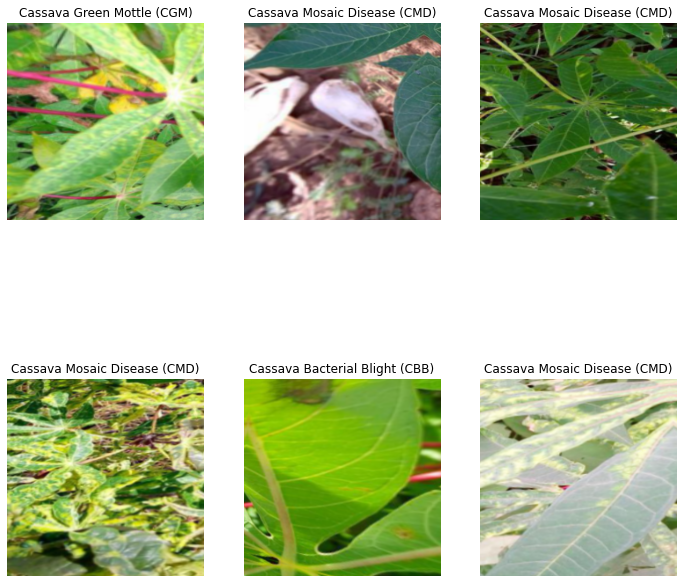

In [18]:
dls.show_batch(nrows = 2, ncols =3, figsize = (12, 12))

In [19]:
model = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


##  Finding an optimal learning rate to train our model with

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.0964781722577754e-06)

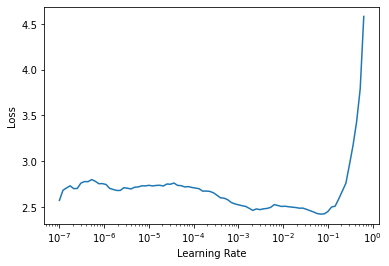

In [20]:
model.lr_find()

* From our plot we find that the learning rate starts decreasing from 1e-5 to inbetween (1e-3-1e-2)
* Lets choose a learning rate below 1e-1 as our loss shoots up from then on
* Lets take base_lr to start with as 1e-3 where our model starts decreasing towards an optimum

In [21]:
model.fine_tune(5, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.307675,1.250065,0.593830,06:18


epoch,train_loss,valid_loss,accuracy,time
0,0.990639,0.920593,0.741762,06:19
1,0.836768,0.829038,0.794578,06:18
2,0.784646,0.791312,0.803692,06:19
3,0.767455,0.726514,0.831269,06:18
4,0.742288,0.747647,0.829166,06:19


In [22]:
model.unfreeze()

SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=7.585775847473997e-07)

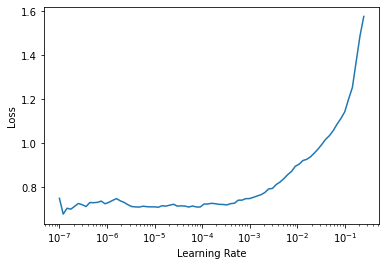

In [23]:
model.lr_find()

In [24]:
model.fit_one_cycle(7, lr_max = slice(1e-6 , 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.740512,0.724275,0.837813,06:19
1,0.749025,0.781418,0.818182,06:20
2,0.733476,0.750754,0.832905,06:19
3,0.730211,0.738989,0.839448,06:19
4,0.699641,0.715957,0.846226,06:19
5,0.676159,0.739027,0.837813,06:21
6,0.648999,0.721438,0.844824,06:18


In [25]:
model.save('model1')

Path('models/model1.pth')

In [26]:
model = model.load('model1')

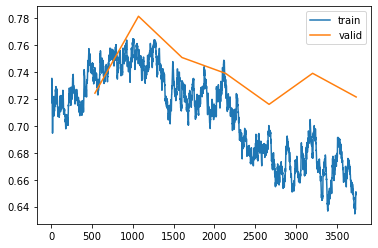

In [27]:
model.recorder.plot_loss()

In [28]:
model.export()

## **Actual versus Predicted**

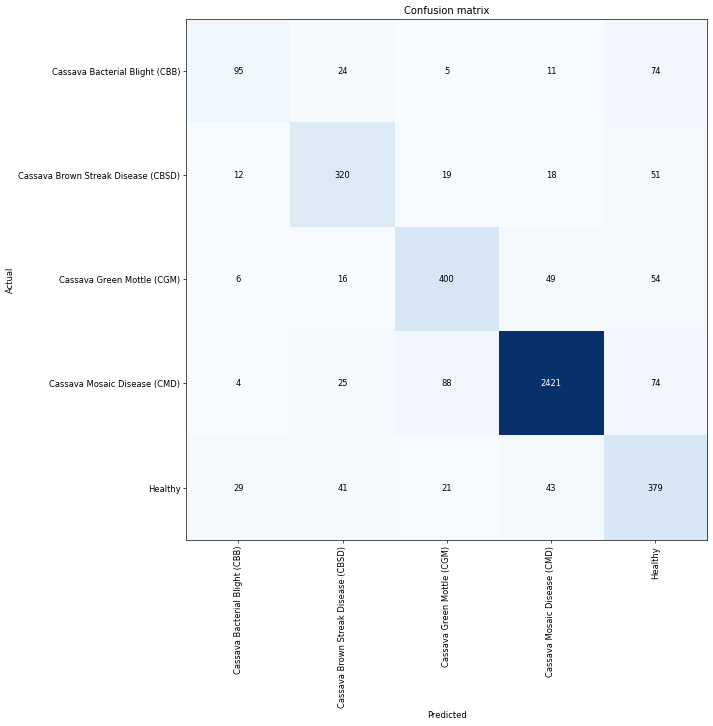

In [29]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

* Some of the labels that our model have predicted shown in our confusion matrix potrays the presence of falsely predicted labels

In [30]:
print(f"Images that our network confuses while training are: /n{interp.most_confused(min_val = 10)}")

Images that our network confuses while training are: /n[('Cassava Mosaic Disease (CMD)', 'Cassava Green Mottle (CGM)', 88), ('Cassava Bacterial Blight (CBB)', 'Healthy', 74), ('Cassava Mosaic Disease (CMD)', 'Healthy', 74), ('Cassava Green Mottle (CGM)', 'Healthy', 54), ('Cassava Brown Streak Disease (CBSD)', 'Healthy', 51), ('Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 49), ('Healthy', 'Cassava Mosaic Disease (CMD)', 43), ('Healthy', 'Cassava Brown Streak Disease (CBSD)', 41), ('Healthy', 'Cassava Bacterial Blight (CBB)', 29), ('Cassava Mosaic Disease (CMD)', 'Cassava Brown Streak Disease (CBSD)', 25), ('Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 24), ('Healthy', 'Cassava Green Mottle (CGM)', 21), ('Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 19), ('Cassava Brown Streak Disease (CBSD)', 'Cassava Mosaic Disease (CMD)', 18), ('Cassava Green Mottle (CGM)', 'Cassava Brown Streak Disease (CBSD)', 16), ('Cassava Brown Str

# **Lets check how good our trained model is at predicting test images**

In [31]:
submission = submission.copy()
submission.head()

,image_id,label
0,2216849948.jpg,4


In [32]:
submission['image_id'] = submission['image_id'].map(lambda y: f"/kaggle/input/cassava-leaf-disease-classification/test_images/{y}")
submission.head()

,image_id,label
0,/kaggle/input/cassava-leaf-disease-classification/test_images/2216849948.jpg,4


In [33]:
test_dl = model.dls.test_dl(submission)

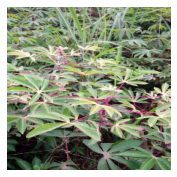

In [34]:
test_dl.show_batch()

**Making predicitons on our test image using fastai's dataloader**

In [35]:
preds, _ = model.get_preds(dl=test_dl)

In [36]:
submission['label'] = preds.argmax(dim = -1).numpy()

In [37]:
submission = submission.replace('/kaggle/input/cassava-leaf-disease-classification/test_images/2216849948.jpg','2216849948.jpg')

In [38]:
submission.head()

,image_id,label
0,2216849948.jpg,4


## **Making a submission**

In [39]:
submission.to_csv('submission.csv', index = False)

In [40]:
submission.head()

,image_id,label
0,2216849948.jpg,4
